# Generative Adversarial Network (GAN)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [2]:
# Use this for CNN
ds_train = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.5,),(0.5,)),
                            ]))

## Process

In [3]:
x,t = ds_train.__getitem__(0)

In [4]:
def draw(X):
    img_size = 28
    def draw_single(x): 
        with torch.no_grad():
            plt.imshow(x.detach().cpu().numpy().reshape((img_size, img_size)), cmap='gray');
            plt.axis('off');
    if len(X.shape)==4 or len(X.shape)==2:  # display a batch
        N = X.shape[0]
        plt.figure(figsize=(15,3))
        for k,xx in enumerate(X):
            plt.subplot(1,10,k+1)
            draw_single(xx)
    else:
        draw_single(X)

In [5]:
# Batched, for training
batch_size_train = 128
train_dl = torch.utils.data.DataLoader(ds_train, batch_size=batch_size_train, shuffle=True)

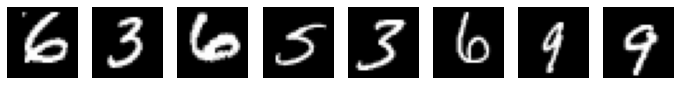

In [6]:
x,t = next(iter(train_dl))
draw(x[:8])

## CNN GAN

In [7]:
class gan(nn.Module):
    def __init__(self):
        super().__init__()
        self.Z_dim = 128
        self.losses_D = []
        self.losses_G = []
        
        self.prob_R = []
        self.prob_F = []
        
        self.Number_Channel = 1
        self.Number_Feature_Dis = 64
        self.Number_Feature_Gen = 64

        # D: Convolution part of the discriminator
        self.D = nn.Sequential(
            nn.Conv2d(self.Number_Channel, self.Number_Feature_Dis, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis) x 14 x 14
            
            nn.Conv2d(self.Number_Feature_Dis, self.Number_Feature_Dis * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Dis * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis*2) x 7 x 7
            
            nn.Conv2d(self.Number_Feature_Dis * 2, self.Number_Feature_Dis * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Dis * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis*4) x 4 x 4
            
            nn.Conv2d(self.Number_Feature_Dis * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
        # G: Generator
        self.G = nn.Sequential(
            
            nn.ConvTranspose2d(self.Z_dim, self.Number_Feature_Gen * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Gen * 4),
            nn.ReLU(True),
            # (Number_Feature_Gen*8) x 4 x 4
            
            nn.ConvTranspose2d(self.Number_Feature_Gen * 4, self.Number_Feature_Gen * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Gen * 2),
            nn.ReLU(True),
            # (Number_Feature_Gen*4) x 8 x 8
            
            nn.ConvTranspose2d(self.Number_Feature_Gen * 2, self.Number_Feature_Gen, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Gen),
            nn.ReLU(True),
            # (Number_Feature_Gen*2) x 16 x 16
            
            nn.ConvTranspose2d(self.Number_Feature_Gen, self.Number_Channel, 4, 2, 1, bias=False),
            # 1 * 28 * 28
            
            nn.Tanh()
        )
        self.D.to(device)
        self.G.to(device)
        
        self.Loss_D = nn.BCELoss()
        self.Loss_G = nn.BCELoss()
        self.to(device)
                
    def forward(self, x):
        return self.discriminate(x)
    
    def discriminate(self, x):
        '''
         y = net.discriminate(x)
         
         Runs the discriminative network on a batch of inputs.
         
         Inputs:
          x   [D,<input shape>] batch of inputs
              where <input shape> is [1,28,28]
          
         Outputs:
          y   Dx1 batch of outputs
        '''
        #z = self.D(x)
        return self.D(x)
        
    def generate(self, n=1):
        '''
         y = net.generate(n=1)
         
         Generates a batch of n inputs using random latent-vector seeds.
         
         Inputs:
          n   number of inputs to generate
          
         Outputs:
          y   [n,<input shape>] batch of generated inputs
              where <input shape> is [1,28,28]
        '''
        z = torch.randn(n, self.Z_dim, 1, 1, device=device)
        return self.G(z)
    
        
    def learn(self, dl, epochs=10, lr=0.0001):
        optimizerD = torch.optim.Adam(self.D.parameters(), lr=lr, betas=(0.5, 0.999))
        optimizerG = torch.optim.Adam(self.G.parameters(), lr=lr, betas=(0.5, 0.999))
        for epoch in tqdm(range(epochs)):
            for x,t in dl:
                real_data = x.to(device)
                batch_size = real_data.size(0)
                label = torch.full((batch_size,), 1., dtype=torch.float, device=device)
                
                # (1) Update D network
                self.D.zero_grad()
                output = self.D(real_data).view(-1)
                errD_real = self.Loss_D(output, label) # label it as real image
                self.prob_R.append(torch.mean(output).item())
                errD_real.backward()
                
                # generate fake image
                noise = torch.randn(batch_size, self.Z_dim, 1, 1, device=device)
                fake_data = self.G(noise)
                label.fill_(0.) # fake label
                output = self.D(fake_data.detach()).view(-1) 
                self.prob_F.append(torch.mean(output).item())
                # Train D with fake image, fake label
                errD_fake = self.Loss_D(output, label)
                errD_fake.backward()
                errD = errD_real + errD_fake
                optimizerD.step()
                
                # Train G
                self.G.zero_grad()        
                label.fill_(1.)  # label real, same fake imgae
                output = self.D(fake_data).view(-1)
                errG = self.Loss_G(output, label)
                errG.backward()
                optimizerG.step()
                
                self.losses_D.append(errD.item())
                self.losses_G.append(errG.item())
        plt.figure(figsize=(30, 10))
        plt.subplot(1, 2, 1)
        plt.plot(net.losses_D); plt.plot(net.losses_G);
        plt.legend(['Disc.', 'Gen.']);
        plt.xlabel('Epochs'); plt.yscale('log');
        
        plt.subplot(1, 2, 2)
        plt.axhline(y=0.5, color='r', linestyle='-')
        plt.plot(net.prob_F); plt.plot(net.prob_R);
        plt.legend(['Fake.', 'Real.']);
        plt.xlabel('Epochs');

# Train it and test it

In [8]:
net = gan()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:11<00:00, 26.25s/it]


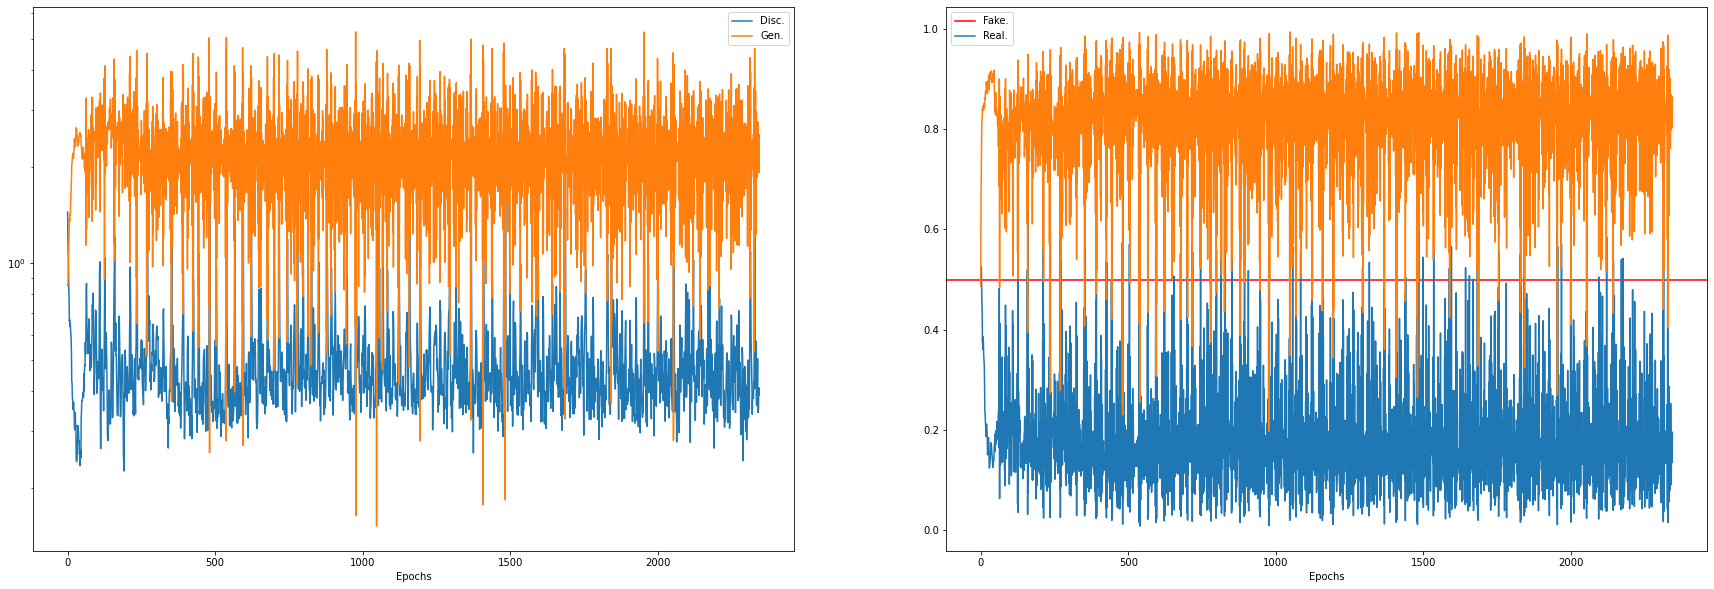

In [9]:
net.learn(train_dl, epochs=5, lr=0.0001)

torch.Size([128, 1, 1, 1])
[[[[0.81816864]]]


 [[[0.790913  ]]]


 [[[0.9235848 ]]]


 [[[0.7129716 ]]]


 [[[0.9805502 ]]]


 [[[0.9963812 ]]]


 [[[0.9930292 ]]]


 [[[0.7130815 ]]]


 [[[0.7647773 ]]]


 [[[0.8829073 ]]]


 [[[0.6811386 ]]]


 [[[0.950009  ]]]


 [[[0.95205164]]]


 [[[0.88217044]]]


 [[[0.9100379 ]]]


 [[[0.9335368 ]]]


 [[[0.9222161 ]]]


 [[[0.93547046]]]


 [[[0.8824778 ]]]


 [[[0.9114222 ]]]


 [[[0.83194613]]]


 [[[0.7698209 ]]]


 [[[0.932046  ]]]


 [[[0.39651528]]]


 [[[0.9570078 ]]]


 [[[0.46962535]]]


 [[[0.79256594]]]


 [[[0.76684195]]]


 [[[0.73359936]]]


 [[[0.67464787]]]


 [[[0.8123565 ]]]


 [[[0.9780572 ]]]


 [[[0.8941447 ]]]


 [[[0.866026  ]]]


 [[[0.45053816]]]


 [[[0.75251174]]]


 [[[0.42576814]]]


 [[[0.99200237]]]


 [[[0.87222224]]]


 [[[0.809833  ]]]


 [[[0.8350052 ]]]


 [[[0.9870625 ]]]


 [[[0.90121   ]]]


 [[[0.8294241 ]]]


 [[[0.56822383]]]


 [[[0.8525463 ]]]


 [[[0.996458  ]]]


 [[[0.95832556]]]


 [[[0.8393355

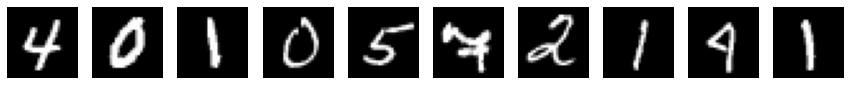

In [10]:
x,t = next(iter(train_dl))
y = net.discriminate(x.to(device))
print(y.shape)
draw(x[:10]);
print(f'{y.detach().cpu().numpy()}')

tensor([[[[0.0256]]],


        [[[0.0586]]],


        [[[0.0025]]],


        [[[0.0022]]],


        [[[0.0334]]],


        [[[0.0377]]],


        [[[0.0040]]],


        [[[0.0042]]],


        [[[0.0083]]],


        [[[0.0041]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


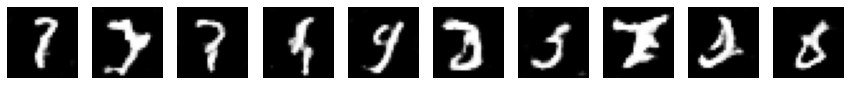

In [11]:
x = net.generate(n=10).to(device)
y = net(x)
draw(x[:10])
print(y)